# Business Understanding
De organisatie wilt graag inzicht verkrijgen in hun werknemersverloop (attrition). Gezien de scope van de opdracht is het lastig om de motivatie van de organisatie te begrijpen. Er wordt een aanname gedaan dat de organisatie kampt met hoge (on)kosten door het werknemersverloop en zij willen graag preventief kunnen handelen om werknemers te behouden. Ze vragen zich af of de kosten lager kunnen zijn door te investeren op werknemersretentie in plaats van te besteden aan recruitment. De organisatie heeft nog geen oplossing naast het werven van nieuwe werknemers.

Er zijn meerdere databronnen beschikbaar gesteld in de vorm van CSV-bestanden. De variabelen uit deze bestanden zullen worden geanalyseerd, waaruit een aantal relevante variabelen geselecteerd worden voor een voorspellend model. Voor de scope en richting van het onderzoek zijn onderstaand een tweetal doelstellingen beschreven.

* Inzicht krijgen in welke variabelen een relatie vormen die werknemersverloop beïnvloeden
* Een model bouwen om werknemersverloop te voorspellen

Tegelijkertijd zal het onderzoek een succes zijn als:

* De organisatie preventief kan handelen om werknemersverloop te minderen
* Kosten verlaagd kunnen worden, die veroorzaakt worden door werknemersverloop

In [4]:
# Importeren van de benodigde libraries
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Understanding
De aangeleverde data komen uit twee verschillende bronnen; vanuit HR (bestaand) en enquêtes (additioneel). Tevens is een data dictionary meegeleverd, zodat uniforme definities gehanteerd worden. Onderstaand een beknopte opsomming van de data.

* Standaard HR-data waarin belangrijke werknemers data (anoniem) staat
* Tweemaal enquête data; één vanuit de werknemers en één vanuit de managers
* Kloktijden met de start en eind timestamps van de shifts

## Definities van de variabelen

| Variabel                 | Omschrijving                                       | Niveau |
| ------------------------ | -------------------------------------------------- | ------ |
| Age                      | Leeftijd werknemer                                 |        |
| Attrition                | De werknemer is vorig jaar weggegaan               |        |
| BusinessTravel           | Frequentie van zakelijke reizen afgelopen jaar     |        |
| Department               | Afdeling binnen het bedrijf                        |        |
| DistanceFromHome         | Afstand vanaf huis in kilometers (km's)            |        |
| Education                | Educatie niveau                                    | 1. Below college <br> 2. College <br> 3. Bachelor <br> 4. Master <br> 5. Doctor |
| EducationField           | Educatie vakgebied                                 |        |
| EmployeeCount            | Aantal werknemers                                  |        |
| EmployeeNumber           | Unieke werknemersnummer (ID)                       |        |
| EnvironmentSatisfaction  | Tevredenheidsniveau van de werkomgeving            | 1. Low <br> 2. Medium <br> 3. High <br> 4. Very High |
| Gender                   | Geslacht                                           |        |
| JobInvolvement           | Niveau van aansluiting tussen werknemer en functie | 1. Low <br> 2. Medium <br> 3. High <br> 4. Very High |
| JobLevel                 | Niveau van functie binnen de organisatie           |        |
| JobRole                  | Naam functie                                       |        |
| JobSatisfaction          | Tevredenheidsniveau over werk                      | 1. Low <br> 2. Medium <br> 3. High <br> 4. Very High |
| MaritalStatus            | Burgelijke staat                                   |        |
| MonthlyIncome            | Maandelijk inkomen in roepies (valuta India)       |        |
| NumCompaniesWorked       | Totaal aantal werkgevers van werknemer             |        |
| Over18                   | Of de werknemer boven de 18 is of niet             |        |
| PercentSalaryHike        | Procentuele salarisverhoging afgelopen jaar        |        |
| PerformanceRating        | Resultaatbeoordeling afgelopen jaar                | 1. Low <br> 2. Good <br> 3. Excellent <br> 4. Outstanding |
| RelationshipSatisfaction | Tevredenheidsniveau van relatie                    | 1. Low <br> 2. Medium <br> 3. High <br> 4. Very High |
| StandardHours            | Standaard werkuren van werknemer                   |        |
| StockOptionLevel         | Aandelenniveau van werknemer                       |        |
| TotalWorkingYears        | Totaal aantal werkjaren van werknemer              |        |
| TrainingTimesLastYear    | Aantal training voor werknemer afgelopen jaar      |        |
| WorkLifeBalance          | Niveau van werk/privé balans                       | 1. Bad <br> 2. Good <br> 3. Better <br> 4. Best |
| YearsAtCompany           | Totaal aantal werkjaren bij de organisatie         |        |
| YearsSinceLastPromotion  | Aantal jaren sinds laatste promotie                |        |
| YearsWithCurrentManager  | Aantal jaar onder huidige manager                  |        |

In [5]:
# Data inlezen
employee_survey_data = pd.read_csv('employee_survey_data.csv')
general_data = pd.read_csv('general_data.csv')
manager_survey_data = pd.read_csv('manager_survey_data.csv')
in_time = pd.read_csv('in_time.csv')
out_time = pd.read_csv('out_time.csv')

# Data samenvoegen
data = pd.merge(
    general_data,
    employee_survey_data,
    on='EmployeeID'
    )

data = pd.merge(data,
                manager_survey_data,
                on='EmployeeID'
                )

## Exploreren van de data

Het exploreren van de data is per set onder elkaar gedaan om verwarring te verkomen.

### general_data

In [6]:
data.head(10)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,9.0,2,6,0,4,4.0,1.0,3.0,3,3
5,46,No,Travel_Rarely,Research & Development,8,3,Life Sciences,1,6,Female,...,28.0,5,7,7,7,3.0,2.0,2.0,3,3
6,28,Yes,Travel_Rarely,Research & Development,11,2,Medical,1,7,Male,...,5.0,2,0,0,0,1.0,3.0,1.0,3,4
7,29,No,Travel_Rarely,Research & Development,18,3,Life Sciences,1,8,Male,...,10.0,2,0,0,0,1.0,2.0,3.0,3,4
8,31,No,Travel_Rarely,Research & Development,1,3,Life Sciences,1,9,Male,...,10.0,2,9,7,8,2.0,4.0,3.0,3,4
9,25,No,Non-Travel,Research & Development,7,4,Medical,1,10,Female,...,6.0,2,6,1,5,2.0,1.0,3.0,3,3


> De eerste 10 rijen van de dataframe

In [7]:
data.shape

(4410, 29)

> Omvang van de dataframe; 29 kolommen en 4410 rijen

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

> Hoeveelheid non-null waarden en de data types van de dataframe

In [9]:
data.describe()

,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
count,4410.000000,4410.000000,4410.000000,4410.0,4410.000000,4410.000000,4410.000000,4391.000000,4410.000000,4410.0,...,4401.000000,4410.000000,4410.000000,4410.000000,4410.000000,4385.000000,4390.000000,4372.000000,4410.000000,4410.000000
mean,36.923810,9.192517,2.912925,1.0,2205.500000,2.063946,65029.312925,2.694830,15.209524,8.0,...,11.279936,2.799320,7.008163,2.187755,4.123129,2.723603,2.728246,2.761436,2.729932,3.153741
std,9.133301,8.105026,1.023933,0.0,1273.201673,1.106689,47068.888559,2.498887,3.659108,0.0,...,7.782222,1.288978,6.125135,3.221699,3.567327,1.092756,1.101253,0.706245,0.711400,0.360742
min,18.000000,1.000000,1.000000,1.0,1.000000,1.000000,10090.000000,0.000000,11.000000,8.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000
25%,30.000000,2.000000,2.000000,1.0,1103.250000,1.000000,29110.000000,1.000000,12.000000,8.0,...,6.000000,2.000000,3.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000
50%,36.000000,7.000000,3.000000,1.0,2205.500000,2.000000,49190.000000,2.000000,14.000000,8.0,...,10.000000,3.000000,5.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,43.000000,14.000000,4.000000,1.0,3307.750000,3.000000,83800.000000,4.000000,18.000000,8.0,...,15.000000,3.000000,9.000000,3.000000,7.000000,4.000000,4.000000,3.000000,3.000000,3.000000
max,60.000000,29.000000,5.000000,1.0,4410.000000,5.000000,199990.000000,9.000000,25.000000,8.0,...,40.000000,6.000000,40.000000,15.000000,17.000000,4.000000,4.000000,4.000000,4.000000,4.000000


> Beschrijvende statistiek van de dataframe

In [10]:
data.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
JobInvolvement              0
PerformanceRating           0
dtype: int64

> Er missen waarden in vijf kolommen van de dataframe: NumCompaniesWorked, TotalWorkingYears, EnvironmentSatisfaction, JobSatisfaction en JobInvolvement (data is vrij compleet)

> RelationshipSatisfaction bestaat niet, staat wel in de data_dictionary

In [11]:
data.duplicated().sum()

0

> Geen redundante data in de dataframe

### in_time

In [12]:
in_time.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,...,NaN,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,NaN,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
1,2,NaN,2015-01-02 10:15:44,2015-01-05 10:21:05,NaN,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,...,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,NaN,NaN,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20
2,3,NaN,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,...,2015-12-18 10:15:14,2015-12-21 10:10:28,2015-12-22 09:44:44,2015-12-23 10:15:54,2015-12-24 10:07:26,NaN,2015-12-28 09:42:05,2015-12-29 09:43:36,2015-12-30 09:34:05,2015-12-31 10:28:39
3,4,NaN,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,...,2015-12-18 10:17:38,2015-12-21 09:58:21,2015-12-22 10:04:25,2015-12-23 10:11:46,2015-12-24 09:43:15,NaN,2015-12-28 09:52:44,2015-12-29 09:33:16,2015-12-30 10:18:12,2015-12-31 10:01:15
4,5,NaN,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,...,2015-12-18 09:58:35,2015-12-21 10:03:41,2015-12-22 10:10:30,2015-12-23 10:13:36,2015-12-24 09:44:24,NaN,2015-12-28 10:05:15,2015-12-29 10:30:53,2015-12-30 09:18:21,2015-12-31 09:41:09


>De eerste vijf rijen van in_time

In [13]:
in_time.shape

(4410, 262)

>Omvang van in_time; 262 kolommen en 4410 rijen

In [14]:
in_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Columns: 262 entries, Unnamed: 0 to 2015-12-31
dtypes: float64(12), int64(1), object(249)
memory usage: 8.8+ MB


>Data types van in_time

In [15]:
in_time.isna().sum()

Unnamed: 0       0
2015-01-01    4410
2015-01-02     209
2015-01-05     206
2015-01-06     228
              ... 
2015-12-25    4410
2015-12-28     234
2015-12-29     230
2015-12-30     265
2015-12-31     213
Length: 262, dtype: int64

>Missende waarden in in_time; wellicht verlof en verzuim ook?

In [16]:
in_time.duplicated().sum()

0

>Geen redundante data in in_time

### out_time

In [17]:
out_time.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 16:56:15,2015-01-05 17:20:11,2015-01-06 17:19:05,2015-01-07 16:34:55,2015-01-08 17:08:32,2015-01-09 17:38:29,2015-01-12 16:58:39,2015-01-13 18:02:58,...,NaN,2015-12-21 17:15:50,2015-12-22 17:27:51,2015-12-23 16:44:44,2015-12-24 17:47:22,NaN,2015-12-28 18:00:07,2015-12-29 17:22:30,2015-12-30 17:40:56,2015-12-31 17:17:33
1,2,NaN,2015-01-02 18:22:17,2015-01-05 17:48:22,NaN,2015-01-07 17:09:06,2015-01-08 17:34:04,2015-01-09 16:52:29,2015-01-12 17:36:48,2015-01-13 18:00:13,...,2015-12-18 18:31:28,2015-12-21 17:34:16,2015-12-22 18:16:35,2015-12-23 17:38:18,NaN,NaN,2015-12-28 17:08:38,2015-12-29 17:54:46,2015-12-30 18:31:35,2015-12-31 17:40:58
2,3,NaN,2015-01-02 16:59:14,2015-01-05 17:06:46,2015-01-06 16:38:32,2015-01-07 16:33:21,2015-01-08 17:24:22,2015-01-09 16:57:30,2015-01-12 17:28:54,2015-01-13 17:21:25,...,2015-12-18 17:02:23,2015-12-21 17:20:17,2015-12-22 16:32:50,2015-12-23 16:59:43,2015-12-24 16:58:25,NaN,2015-12-28 16:43:31,2015-12-29 17:09:56,2015-12-30 17:06:25,2015-12-31 17:15:50
3,4,NaN,2015-01-02 17:25:24,2015-01-05 17:14:03,2015-01-06 17:07:42,2015-01-07 16:32:40,2015-01-08 16:53:11,2015-01-09 17:19:47,2015-01-12 17:13:37,2015-01-13 17:11:45,...,2015-12-18 17:55:23,2015-12-21 16:49:09,2015-12-22 17:24:00,2015-12-23 17:36:35,2015-12-24 16:48:21,NaN,2015-12-28 17:19:34,2015-12-29 16:58:16,2015-12-30 17:40:11,2015-12-31 17:09:14
4,5,NaN,2015-01-02 18:31:37,2015-01-05 17:49:15,2015-01-06 17:26:25,2015-01-07 17:37:59,2015-01-08 17:59:28,2015-01-09 17:44:08,2015-01-12 18:51:21,2015-01-13 18:14:58,...,2015-12-18 17:52:48,2015-12-21 17:43:35,2015-12-22 18:07:57,2015-12-23 18:00:49,2015-12-24 17:59:22,NaN,2015-12-28 17:44:59,2015-12-29 18:47:00,2015-12-30 17:15:33,2015-12-31 17:42:14


>De eerste vijf rijen van out_time

In [18]:
out_time.shape

(4410, 262)

>Omvang van out_time; 262 kolommen en 4410 rijen

In [19]:
out_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Columns: 262 entries, Unnamed: 0 to 2015-12-31
dtypes: float64(12), int64(1), object(249)
memory usage: 8.8+ MB


>Data types van out_time

In [20]:
out_time.isna().sum()

Unnamed: 0       0
2015-01-01    4410
2015-01-02     209
2015-01-05     206
2015-01-06     228
              ... 
2015-12-25    4410
2015-12-28     234
2015-12-29     230
2015-12-30     265
2015-12-31     213
Length: 262, dtype: int64

>Missende waarden in out_time; wellicht ook verlof en verzuim?

In [21]:
out_time.duplicated().sum()

0

>Geen redundante data in out_time

# Data Preparation

Kijken met wat voor soort categorische data we te maken hebben en welke overwegingen genomen moeten worden. Eerst worden de unieke waarden uit de kolommen per dataset gehaald en onderverdeeld in de nominale en ordinale categorieën. Daarna zal middels explorerende data-analyse (EDA) de relaties en patronen op het eerste gezicht gevisualiseerd worden. Tevens moet ook besloten worden wat met missende waarden gedaan worden; verwijderen of imputeren.

## Belangrijke overwegingen

1. De kloktijddata bevatten de unieke werknemers-ID in naamloze kolom; omzetten naar EmployeeID voor eventuele integratie
2. Kloktijden omzetten naar datetime-objecten voor analyse
3. Andere data omzetten naar andere data types om memory usage te verlagen, performance te verhogen en analyses voor te bereiden
4. Missende waarden verwijderen of imputeren in pipeline

## Unieke waarden van categorische data

### dataframe

In [22]:
# Unieke waarden van categorische data
for column in data.select_dtypes(include='object').columns:         # Selecteer alle kolommen met object data type
    unique_values = data[column].unique()                           # Selecteer alle unieke waarden van de kolom
    print(                                                          # Print de kolomnaam en unieke waarden
        f"Column: {column}\nUnique values: {unique_values}\n"
        )

Column: Attrition
Unique values: ['No' 'Yes']

Column: BusinessTravel
Unique values: ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']

Column: Department
Unique values: ['Sales' 'Research & Development' 'Human Resources']

Column: EducationField
Unique values: ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']

Column: Gender
Unique values: ['Female' 'Male']

Column: JobRole
Unique values: ['Healthcare Representative' 'Research Scientist' 'Sales Executive'
 'Human Resources' 'Research Director' 'Laboratory Technician'
 'Manufacturing Director' 'Sales Representative' 'Manager']

Column: MaritalStatus
Unique values: ['Married' 'Single' 'Divorced']

Column: Over18
Unique values: ['Y']



### Zijn er werknemers onder de 18?

In [23]:
# Variabelen voor for loop
over18_counts = data['Over18'].value_counts()                               # Aantal werknemers boven de 18
total_rows = len(data)                                                      # Totaal aantal rijen in de dataset

# Print de waarden, aantal en percentage van werknemers boven de 18
for value, count in over18_counts.items():                                  # Loop door de unieke waarden en aantallen
    percentage = (count / total_rows) * 100                                 # Bereken het percentage
    print(                                                                  # Print de waarden, aantal en percentage
        f"Value: {value}, Count: {count}, Percentage: {percentage}%"
        )

Value: Y, Count: 4410, Percentage: 100.0%


> Nee, dus deze feature is irrelevant, want iedereen is boven de 18

### dataframe subsetten zonder kolom Over18

In [24]:
data_subset = data.drop("Over18", axis=1)                                  # Verwijder de kolom Over18

# Unieke waarden van categorische data
for column in data_subset.select_dtypes(include='object').columns:         # Selecteer alle kolommen met object data type
    unique_values = data_subset[column].unique()                           # Selecteer alle unieke waarden van de kolom
    print(                                                                 # Print de kolomnaam en unieke waarden
        f"Column: {column}\nUnique values: {unique_values}\n"
        )

Column: Attrition
Unique values: ['No' 'Yes']

Column: BusinessTravel
Unique values: ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']

Column: Department
Unique values: ['Sales' 'Research & Development' 'Human Resources']

Column: EducationField
Unique values: ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']

Column: Gender
Unique values: ['Female' 'Male']

Column: JobRole
Unique values: ['Healthcare Representative' 'Research Scientist' 'Sales Executive'
 'Human Resources' 'Research Director' 'Laboratory Technician'
 'Manufacturing Director' 'Sales Representative' 'Manager']

Column: MaritalStatus
Unique values: ['Married' 'Single' 'Divorced']



### Floats omzetten naar ints

In [25]:
# Unieke waarden van float data
data_floats = [column for column in data.columns if data[column].dtype == 'float64']

for column in data_subset[data_floats].columns:
    print(f"Column: {column}\n{data_subset[column].unique()}\n")

Column: NumCompaniesWorked
[ 1.  0.  3.  4.  2.  7.  9.  5.  6.  8. nan]

Column: TotalWorkingYears
[ 1.  6.  5. 13.  9. 28. 10. 21. 16. 37.  7.  3. 15.  8. nan 12. 17. 19.
 22.  2.  4. 23.  0. 11. 24. 25. 20. 14. 26. 18. 30. 36. 31. 33. 32. 34.
 40. 29. 35. 27. 38.]

Column: EnvironmentSatisfaction
[ 3.  2.  4.  1. nan]

Column: JobSatisfaction
[ 4.  2.  1.  3. nan]

Column: WorkLifeBalance
[ 2.  4.  1.  3. nan]



In [26]:
# Float data naar integer data
data_subset[data_floats] = data_subset[data_floats].astype('Int64')

# Resultaat
data_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      4410 non-null   int64 
 1   Attrition                4410 non-null   object
 2   BusinessTravel           4410 non-null   object
 3   Department               4410 non-null   object
 4   DistanceFromHome         4410 non-null   int64 
 5   Education                4410 non-null   int64 
 6   EducationField           4410 non-null   object
 7   EmployeeCount            4410 non-null   int64 
 8   EmployeeID               4410 non-null   int64 
 9   Gender                   4410 non-null   object
 10  JobLevel                 4410 non-null   int64 
 11  JobRole                  4410 non-null   object
 12  MaritalStatus            4410 non-null   object
 13  MonthlyIncome            4410 non-null   int64 
 14  NumCompaniesWorked       4391 non-null  

### Kopieren van dataset voor nummeriek en category

In [27]:
# Kopie van de dataset
data_subset_cat = data_subset.copy()
data_subset_num = data_subset.copy()

### Kolommen met object dtype omzetten naar category voor nominale data

In [28]:
# Selecteer alle kolommen met dtype object
object_columns = data_subset_cat.select_dtypes(include='object').columns

# Omzetten naar dtype category
data_subset_cat[object_columns] = data_subset_cat[object_columns].astype('category')

# Unieke waarden van categorische data
for column in data_subset_cat.select_dtypes(include='category').columns:       # Selecteer alle kolommen met category dtype
    unique_values = data_subset_cat[column].unique()                           # Selecteer alle unieke waarden van de kolom
    print(                                                                 # Print de kolomnaam en unieke waarden
        f"Column: {column}\nUnique values: {unique_values}\n"
        )

Column: Attrition
Unique values: ['No', 'Yes']
Categories (2, object): ['No', 'Yes']

Column: BusinessTravel
Unique values: ['Travel_Rarely', 'Travel_Frequently', 'Non-Travel']
Categories (3, object): ['Non-Travel', 'Travel_Frequently', 'Travel_Rarely']

Column: Department
Unique values: ['Sales', 'Research & Development', 'Human Resources']
Categories (3, object): ['Human Resources', 'Research & Development', 'Sales']

Column: EducationField
Unique values: ['Life Sciences', 'Other', 'Medical', 'Marketing', 'Technical Degree', 'Human Resources']
Categories (6, object): ['Human Resources', 'Life Sciences', 'Marketing', 'Medical', 'Other', 'Technical Degree']

Column: Gender
Unique values: ['Female', 'Male']
Categories (2, object): ['Female', 'Male']

Column: JobRole
Unique values: ['Healthcare Representative', 'Research Scientist', 'Sales Executive', 'Human Resources', 'Research Director', 'Laboratory Technician', 'Manufacturing Director', 'Sales Representative', 'Manager']
Categories (

### Mapping voor nummeriek converteren naar string/category

In [29]:
# Ordinale kolommen selecteren; deze kolommen hebben een logische volgorde
ordinal_mapping = {
    "Education": {
        1: "Below College",
        2: "College",
        3: "Bachelor",
        4: "Master",
        5: "Doctor"
        },
    "EnvironmentSatisfaction": {
        1: "Low",
        2: "Medium",
        3: "High",
        4: "Very High"
        },
    "JobInvolvement": {
        1: "Low",
        2: "Medium",
        3: "High",
        4: "Very High"
        },
    "JobLevel": {
        1: "Entry",
        2: "Mid",
        3: "Senior",
        4: "Manager",
        5: "Director"
        },
    "JobSatisfaction": {
        1: "Low",
        2: "Medium",
        3: "High",
        4: "Very High"
        },
    "PerformanceRating": {
        1: "Low",
        2: "Good",
        3: "Excellent",
        4: "Outstanding"
        },
    "StockOptionLevel": {
        0: "Low",
        1: "Medium",
        2: "High",
        3: "Very High"
        },
    "WorkLifeBalance": {
        1: "Bad",
        2: "Good",
        3: "Better",
        4: "Best"
        }
    }

### Ordinale data kolommen omzetten naar dtype object voor remappen

In [30]:
# Dictionary keys gebruiken om de kolommen te selecteren
for column in ordinal_mapping.keys():
    if column in data_subset_cat.columns:                                   # Controleer of de kolom bestaat in de DataFrame
        data_subset_cat[column] = data_subset_cat[column].astype('object')  # Omzetten naar het datatype 'object'

# Controleer de resultaten
print(data_subset_cat.dtypes[data_subset_cat.dtypes == 'object'])

Education                  object
JobLevel                   object
StockOptionLevel           object
EnvironmentSatisfaction    object
JobSatisfaction            object
WorkLifeBalance            object
JobInvolvement             object
PerformanceRating          object
dtype: object


### Remappen van waarden

In [31]:
# Mapping toepassen op de kolommen
for column, mapping in ordinal_mapping.items():
    if column in data_subset_cat.columns:                                                               # Controleer of de kolom bestaat in de DataFrame
        data_subset_cat[column] = data_subset_cat[column].map(mapping).fillna(data_subset_cat[column])  # Mapping toepassen

# Controleer de resultaten
data_subset_cat.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,51,No,Travel_Rarely,Sales,6,College,Life Sciences,1,1,Female,...,1,6,1,0,0,High,Very High,Good,High,Excellent
1,31,Yes,Travel_Frequently,Research & Development,10,Below College,Life Sciences,1,2,Female,...,6,3,5,1,4,High,Medium,Best,Medium,Outstanding
2,32,No,Travel_Frequently,Research & Development,17,Master,Other,1,3,Male,...,5,2,5,0,3,Medium,Medium,Bad,High,Excellent
3,38,No,Non-Travel,Research & Development,2,Doctor,Life Sciences,1,4,Male,...,13,5,8,7,5,Very High,Very High,Better,Medium,Excellent
4,32,No,Travel_Rarely,Research & Development,10,Below College,Medical,1,5,Male,...,9,2,6,0,4,Very High,Low,Better,High,Excellent


### Ordinale category dtype dataset

In [32]:
# Dictionary keys gebruiken om de kolommen te selecteren
for column, mapping in ordinal_mapping.items():
    ordered_labels = [label for key, label in sorted(mapping.items())]      # Sorteer de labels
    cat_type = CategoricalDtype(categories=ordered_labels, ordered=True)    # Maak een CategoricalDtype object
    data_subset_cat[column] = data_subset_cat[column].astype(cat_type)      # Omzetten naar het CategoricalDtype object

# Controleer de resultaten
data_subset_cat.dtypes

Age                           int64
Attrition                  category
BusinessTravel             category
Department                 category
DistanceFromHome              int64
Education                  category
EducationField             category
EmployeeCount                 int64
EmployeeID                    int64
Gender                     category
JobLevel                   category
JobRole                    category
MaritalStatus              category
MonthlyIncome                 int64
NumCompaniesWorked            Int64
PercentSalaryHike             int64
StandardHours                 int64
StockOptionLevel           category
TotalWorkingYears             Int64
TrainingTimesLastYear         int64
YearsAtCompany                int64
YearsSinceLastPromotion       int64
YearsWithCurrManager          int64
EnvironmentSatisfaction    category
JobSatisfaction            category
WorkLifeBalance            category
JobInvolvement             category
PerformanceRating          c

### Nummerieke dataset waarop label encoding toegepast kan worden voor object dtypes

In [33]:
data_subset_num.dtypes

Age                         int64
Attrition                  object
BusinessTravel             object
Department                 object
DistanceFromHome            int64
Education                   int64
EducationField             object
EmployeeCount               int64
EmployeeID                  int64
Gender                     object
JobLevel                    int64
JobRole                    object
MaritalStatus              object
MonthlyIncome               int64
NumCompaniesWorked          Int64
PercentSalaryHike           int64
StandardHours               int64
StockOptionLevel            int64
TotalWorkingYears           Int64
TrainingTimesLastYear       int64
YearsAtCompany              int64
YearsSinceLastPromotion     int64
YearsWithCurrManager        int64
EnvironmentSatisfaction     Int64
JobSatisfaction             Int64
WorkLifeBalance             Int64
JobInvolvement              int64
PerformanceRating           int64
dtype: object

## Kloktijddata prepareren

### Indexen naar kolom zetten met dezelfde naamconventie

In [34]:
# Kolomnamen aanpassen van kloktijden indexen
in_time.rename(                                     # Hernoemen van de kolomnaam
    columns={                                       # Dictionary met oude en nieuwe kolomnaam
        in_time.columns[0]: 'EmployeeID'            # Oude en nieuwe kolomnaam
        },
    inplace=True                                    # Hernoemen van kolomnaam
    )

out_time.rename(                                    # Hernoemen van de kolomnaam
    columns={                                       # Dictionary met oude en nieuwe kolomnaam
        out_time.columns[0]: 'EmployeeID'           # Oude en nieuwe kolomnaam
        },
    inplace=True                                    # Hernoemen van kolomnaam
    )

### Datatypes wijzigen naar datetime objecten

In [35]:
# Kloktijden omzetten naar datetime
for column in in_time.columns:                      # Loop over de kolommen van de in_time dataframe
    if column != 'EmployeeID':                      # Als de kolom niet 'EmployeeID' is
        in_time[column] = pd.to_datetime(           # Zet de kolom om naar datetime
            in_time[column],                        # De kolom die omgezet moet worden van de loop-variable
            format='%Y-%m-%d %H:%M:%S'              # Het format van datetime
            )

for column in out_time.columns:                     # Loop over de kolommen van de out_time dataframe
    if column != 'EmployeeID':                      # Als de kolom niet 'EmployeeID' is
        out_time[column] = pd.to_datetime(          # Zet de kolom om naar datetime
            out_time[column],                       # De kolom die omgezet moet worden van de loop-variable
            format='%Y-%m-%d %H:%M:%S'              # Het format van datetime
            )

In [36]:
in_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Columns: 262 entries, EmployeeID to 2015-12-31
dtypes: datetime64[ns](261), int64(1)
memory usage: 8.8 MB


In [37]:
out_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Columns: 262 entries, EmployeeID to 2015-12-31
dtypes: datetime64[ns](261), int64(1)
memory usage: 8.8 MB


# Exploratory Data Analysis (EDA)

In [38]:
# Telling van Attrition
data_subset_cat['Attrition'].value_counts()

Attrition
No     3699
Yes     711
Name: count, dtype: int64

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


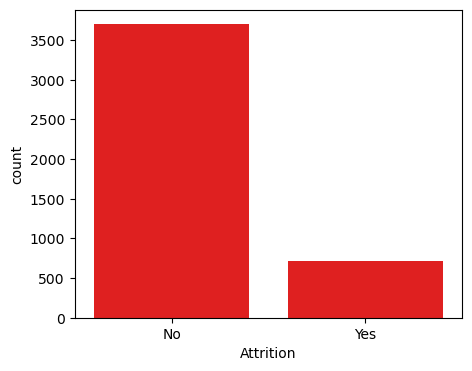

In [39]:
plt.figure(
    figsize=(5,4)
    )

sns.countplot(
    data=data_subset_cat,
    x=data_subset_cat["Attrition"],
    color="red"
    )

plt.show()

In [40]:
data_subset_cat["Education"].value_counts()

Education
Bachelor         1716
Master           1194
College           846
Below College     510
Doctor            144
Name: count, dtype: int64

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='Education', ylabel='count'>

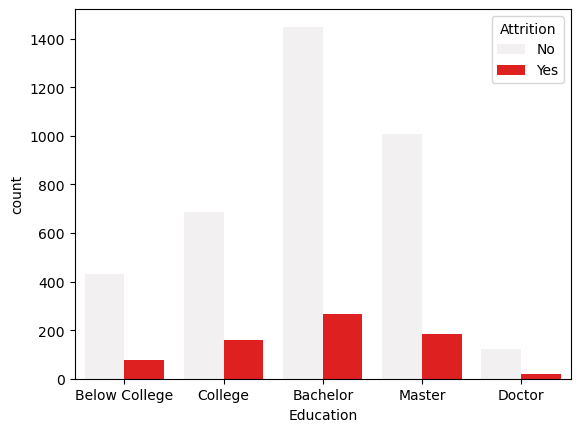

In [41]:
sns.countplot(
    data=data_subset_cat,
    x= data_subset_cat["Education"],
    hue="Attrition",
    color="red"
    )

> Op het eerste gezicht lijkt het dat de meeste werknemers bij de organisatie blijven

In [51]:
data_subset_cat["EducationField"].value_counts()

EducationField
Life Sciences       1818
Medical             1392
Marketing            477
Technical Degree     396
Other                246
Human Resources       81
Name: count, dtype: int64

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='EducationField', ylabel='count'>

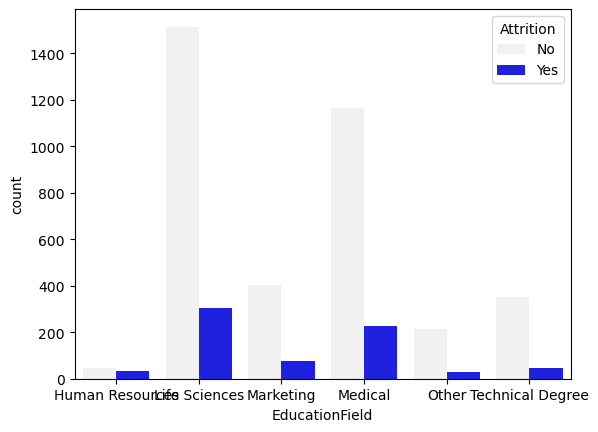

In [54]:
sns.countplot(
    data=data_subset_cat,
    x= data_subset_cat["EducationField"],
    hue="Attrition",
    color="blue",
    )

In [42]:
data_subset_cat["Gender"].value_counts()

Gender
Male      2646
Female    1764
Name: count, dtype: int64

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='Gender', ylabel='count'>

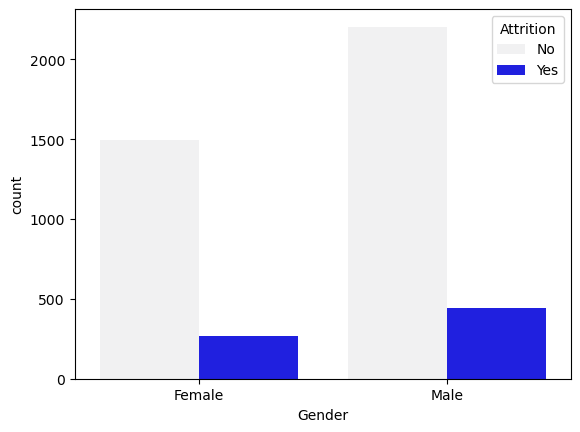

In [43]:
sns.countplot(
    data=data_subset_cat,
    x= data_subset_cat["Gender"],
    hue="Attrition",
    color="blue"
    )

> Verloop onder mannen en vrouwen lijken gemiddeld hetzelfde; vrouwen wellicht iets meer ten opzichte van totale aantal

In [47]:
data_subset_cat["Department"].value_counts()

Department
Research & Development    2883
Sales                     1338
Human Resources            189
Name: count, dtype: int64

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='Department', ylabel='count'>

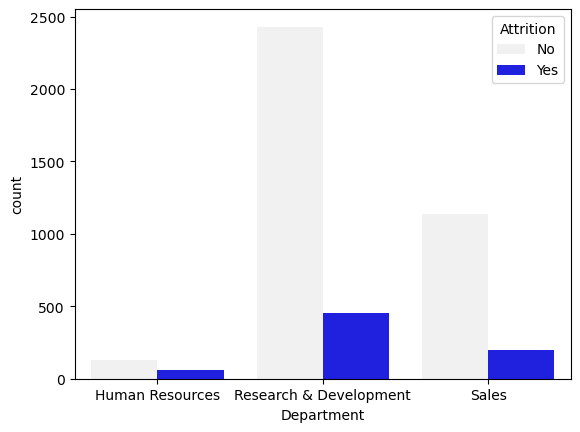

In [48]:
sns.countplot(
    data=data_subset_cat,
    x= data_subset_cat["Department"],
    hue="Attrition",
    color="blue"
    )

In [49]:
data_subset_cat["BusinessTravel"].value_counts()

BusinessTravel
Travel_Rarely        3129
Travel_Frequently     831
Non-Travel            450
Name: count, dtype: int64

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='BusinessTravel', ylabel='count'>

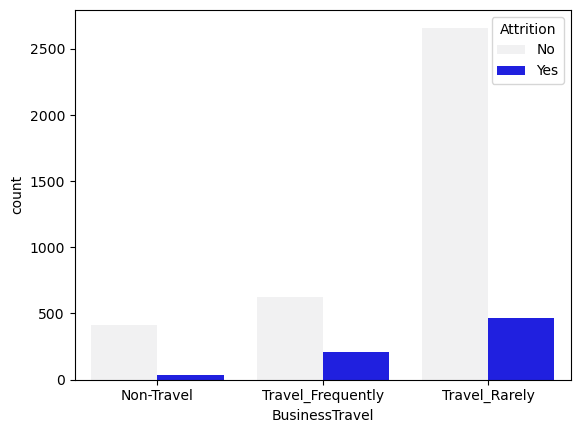

In [50]:
sns.countplot(
    data=data_subset_cat,
    x= data_subset_cat["BusinessTravel"],
    hue="Attrition",
    color="blue"
    )